In [2]:
import os
os.chdir('../FlappyBirdAI')

In [3]:
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import transforms

import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

from game import GameState
from net import Model

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## Testing out Image Transforms

In [3]:
# loading image
img_raw = Image.open("../notebooks/example_frame.png")
img_raw = img_raw.convert('RGB')
img = np.array(img_raw)
img.shape

(750, 993, 3)

In [4]:
# converts to grayscale, resizes it and converts it into Tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((80, 80)),
    transforms.ToTensor()
])
res = transform(img)
s_t = torch.stack([res for _ in range(4)])
print("image input size in pytorch = (N, Cin, H, W)")
print(f"res.shape: {res.shape} (Cin, H, W)\ns_t.shape: {s_t.shape}")

image input size in pytorch = (N, Cin, H, W)
res.shape: torch.Size([1, 80, 80]) (Cin, H, W)
s_t.shape: torch.Size([4, 1, 80, 80])


## Training

In [4]:
# initializing stuff

# defining variables
NUM_ACTIONS: int = 2
MAX_REPLAY: int = 500000
D: deque = deque()

# setup
cudnn.benchmark = True

# setting up transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((80, 80)),
#     transforms.ToTensor()
])

# creating replay memory
D = deque()

In [5]:
# establishing connection with emulator
game_state = GameState(res_folder="../res")

In [6]:
# getting first frame
actions = np.zeros(NUM_ACTIONS)
actions[0] = 1 # no flap
frame, reward, is_terminal = game_state.step(actions)
frame_q = transform(frame)

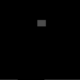

In [9]:
frame_q

In [11]:
s_t = torch.stack([transforms.ToTensor()(frame_q) for _ in range(4)])
s_t.shape

torch.Size([4, 1, 80, 80])

## General Steps involved
1. set value of $\epsilon$ to initial value (1)
2. $t=0$
3. repeat in while loop:
4. forward pass network, get `output`
5. initialize `action_t` array
6. if $t$ % `FRAMES_PER_ACTION` is 0 (e.g. act every 4 frames), then 
    - if random number < $\epsilon$, choose random action. else `argmax(output)` as action.
7. else, do nothing
8. scale down epsilon
9. `frame`, `reward_t`, `is_terminal`=step emulator using action
10. process `frame`
11. append processed `frame` to `s_t` out of place. rename to `s_t1`.
12. add $(s_t, action_t, reward_t, s_{t1}, is\_terminal)$ to replay memory `D`
13. check if replay memory length has exceeded max. if it has, pop left.
14. do the following steps only if replay memory is populated ($t$ > `OBSERVE`)
    - sample a minibatch from `D`, extract values
    - `s_j_out` = forward pass `s_t` of all the samples in the batch. It is the rewards of each possible action given the state `s_j`.
    - `s_j1_out` = forward pass `s_t1` of all the samples in the batch. It is the rewards of each possible action given the state `s_j1`.
    - `optimal` = empty array
    - for sample in minibatch
        - `optimal[j]` = `reward_j`, if `is_terminal`, else `reward_j` * `GAMMA` + `max(s_j1_out[j])`
    - `observed` = `reduce_mean`(`s_j_out` * `a_t`)
    - calculate mean squared loss between `optimal` and `observed`
    - step optimizer